# Mimicking Star Wars Characters Using Neural Networks

Hello! The aim of this NoteBook is to implement different Neural Networks capable of generate dialogue texts of different Star Wars characters. We will implement it using the Keras library and the Tensorflow backend.

![IMG](https://media.giphy.com/media/3ornk57KwDXf81rjWM/giphy.gif)

Well, first things first: let's import our libraries:

In [48]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

options(warn = -1)

library(wordcloud) # Word Clouds
library(jpeg) # Read .JPEG
library(png) # Read .PNG
library(RCurl) # Get contents from URLs
library(RColorBrewer) # Color Scheme to the Word Cloud
library(scales) # Custom scales to Ggplot
library(repr) # Resize R plots in Jupyter Notebooks
library(tidyverse) # Metapackage with lots of helpful functions
library(tensorflow) # Deep learning backend
library(kerasR) # Use Keras' Early Stopping
library(caret) # Use in K-Fold split
library(keras) # API that interacts with tensorflow
library(gridExtra) # Multiple ggplots same figure
library(magrittr) # Enable pipe operator

options(warn = 0)

## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

character(0)

In [49]:
# input.dir <- '/kaggle/input/star-wars-movie-scripts/'
input.dir <- './star-wars-movie-scripts/'
options(repr.plot.width=8)

The basic steps we will follow is to:
1. Analyse the Dataset
2. Prepare the Data
3. Implement the Models
4. Test the Models
5. Take Conclusions

# 1A. Data Analysis - PART I: Checking the File
Let's start by taking a look at the input data:

In [50]:
filterText <- function(text.in) {
    strsplit(gsub('[^[:alnum:] \']|?|!', '', text.in) %>% tolower, ' ') %>%
    unlist %>% (function(X) X[X != '']) %>% return
}

formatScriptText <- function(file.name) {
    
    read.delim(paste(c(input.dir, file.name), collapse = ''), stringsAsFactors = FALSE) %>% 

    mutate(words.list = lapply(character.dialogue, filterText)) %>% 
    mutate(ID = lapply(words.list, (function(X) X[1]))) %>%
    mutate(Character = lapply(words.list, (function(X) X[2])) %>% unlist) %>%
    mutate(Words.List = lapply(words.list, (function(X) tail(X, -2)))) %>%
                                            
    select(c('ID', 'Character', 'Words.List')) %>% return
}
                                            
'SW_EpisodeIV.txt' %>% formatScriptText %>% head

ID,Character,Words.List
<list>,<chr>,<list>
1,threepio,"did , you , hear , that , they've , shut , down , the , main , reactor , we'll , be , destroyed, for , sure , this , is , madness"
2,threepio,"we're , doomed"
3,threepio,"there'll, be , no , escape , for , the , princess, this , time"
4,threepio,"what's, that"
5,threepio,"i , should , have , known , better , than , to , trust , the , logic , of , a , halfsized , thermocapsulary, dehousing , assister"
6,luke,"hurry , up , come , with , me , what , are , you , waiting, for , get , in , gear"


We have a text file and we can get the ID of the dialogue text, the character name and the text itself by processing the generated text, which is represented by a 1-column dataframe:

Then we can put the dataframe of each episode on the same structure and add a column to show the episode of eatch dialogue text:

In [51]:
df_ep4 <- formatScriptText('SW_EpisodeIV.txt')
df_ep5 <- formatScriptText('SW_EpisodeV.txt')
df_ep6 <- formatScriptText('SW_EpisodeVI.txt')

df_ep4$Episode <- '4'
df_ep5$Episode <- '5'
df_ep6$Episode <- '6'

df_all <- bind_rows(bind_rows(df_ep4, df_ep5), df_ep6)
head(df_all)

ID,Character,Words.List,Episode
<list>,<chr>,<list>,<chr>
1,threepio,"did , you , hear , that , they've , shut , down , the , main , reactor , we'll , be , destroyed, for , sure , this , is , madness",4
2,threepio,"we're , doomed",4
3,threepio,"there'll, be , no , escape , for , the , princess, this , time",4
4,threepio,"what's, that",4
5,threepio,"i , should , have , known , better , than , to , trust , the , logic , of , a , halfsized , thermocapsulary, dehousing , assister",4
6,luke,"hurry , up , come , with , me , what , are , you , waiting, for , get , in , gear",4


In a movie, some characters never appears and we need to have a nice amount of words to train a good model, so we can get all the characters that appeared more than a minimum number of times:

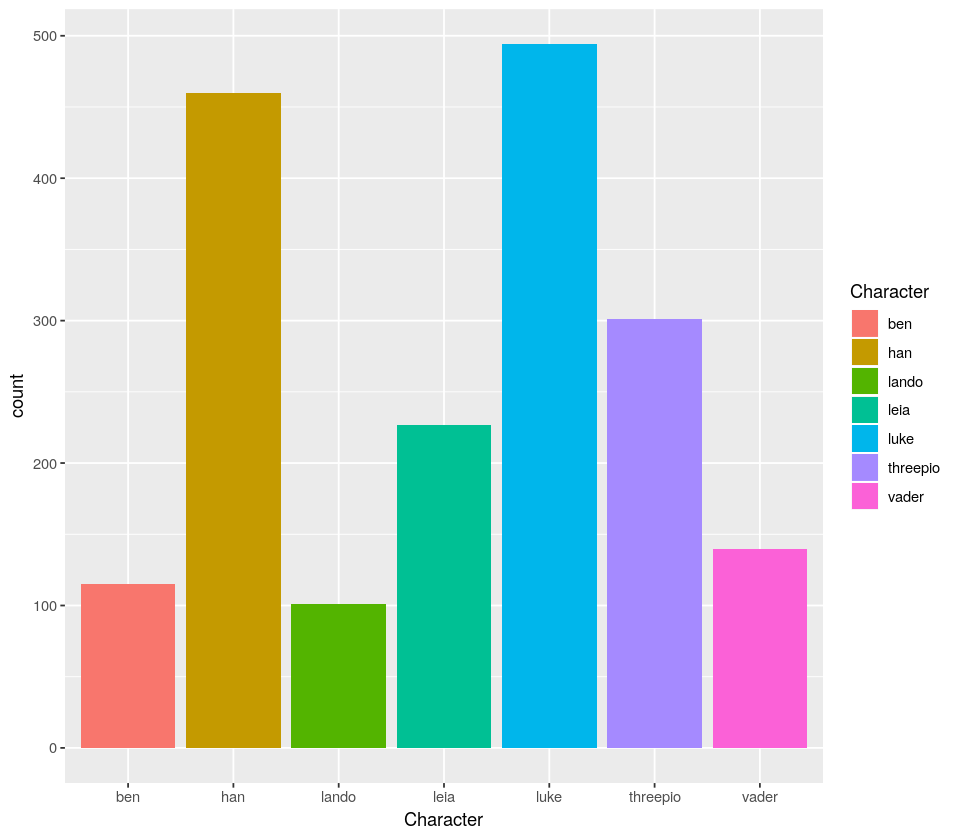

In [52]:
min_appearance = 100
df_main_characters <- df_all %>% 
                      group_by(Character) %>% 
                      mutate(count = n()) %>%
                      filter(count > min_appearance)
ggplot(df_main_characters, aes(x = Character, fill = Character)) + 
    geom_bar(stat = 'count')

There is a **HUGE** problem here: where is Yoda? In our model should Yoda be.

![YODA](https://media.giphy.com/media/3ohuAxV0DfcLTxVh6w/giphy.gif)

So, we are going to add an extra condition to our filter: if the Character equals Yoda, then the row will be considered in our analysis!

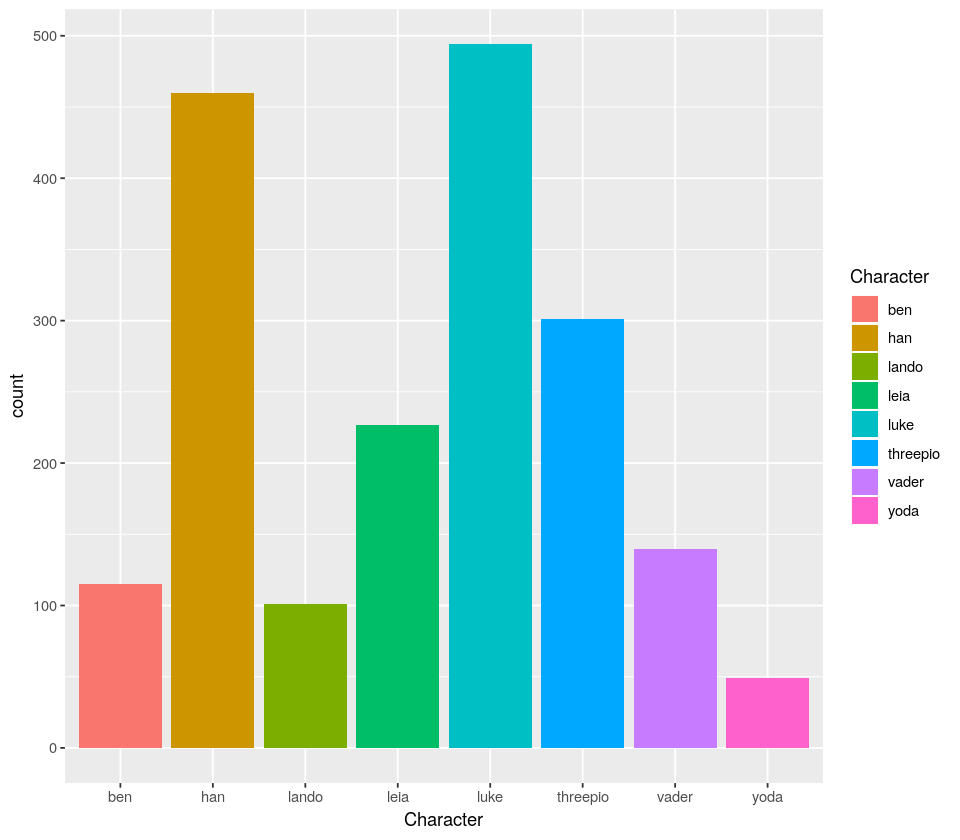

In [53]:
df_main_characters <- df_all %>% 
                      group_by(Character) %>% 
                      mutate(count = n()) %>%
                      filter(count > min_appearance | Character == 'yoda') %>%
                      select(-c('count'))

ggplot(df_main_characters, aes(x = Character, fill = Character)) + geom_bar(stat = 'count')

Much better! Actually we are not interested in taking the number of appearances, we want the number of spoken words. But the number of appearances is a proxy of this quantity as we can check below:

In [54]:
df_main_characters <- df_main_characters %>% mutate(N.Words = lapply(Words.List, (function(X) length(X))) %>% unlist)
df_main_characters_statistics <- df_main_characters %>% 
                                 group_by(Character) %>% 
                                 summarise(Total.Words = sum(N.Words), N.Appearances = n()) %>%
                                 mutate(Words.Per.Appearance = Total.Words / N.Appearances) %>%
                                 as.data.frame
                                                                                  
df_main_characters_statistics

Character,Total.Words,N.Appearances,Words.Per.Appearance
<chr>,<int>,<int>,<dbl>
ben,1838,115,15.982609
han,4260,460,9.260870
lando,1027,101,10.168317
leia,1760,227,7.753304
luke,4481,494,9.070850
threepio,3542,301,11.767442
vader,1539,140,10.992857
yoda,794,49,16.204082


The Words / Appearances doesn't seem to change much. Also, the Total.Words seems to follow the N.Appearances variable.

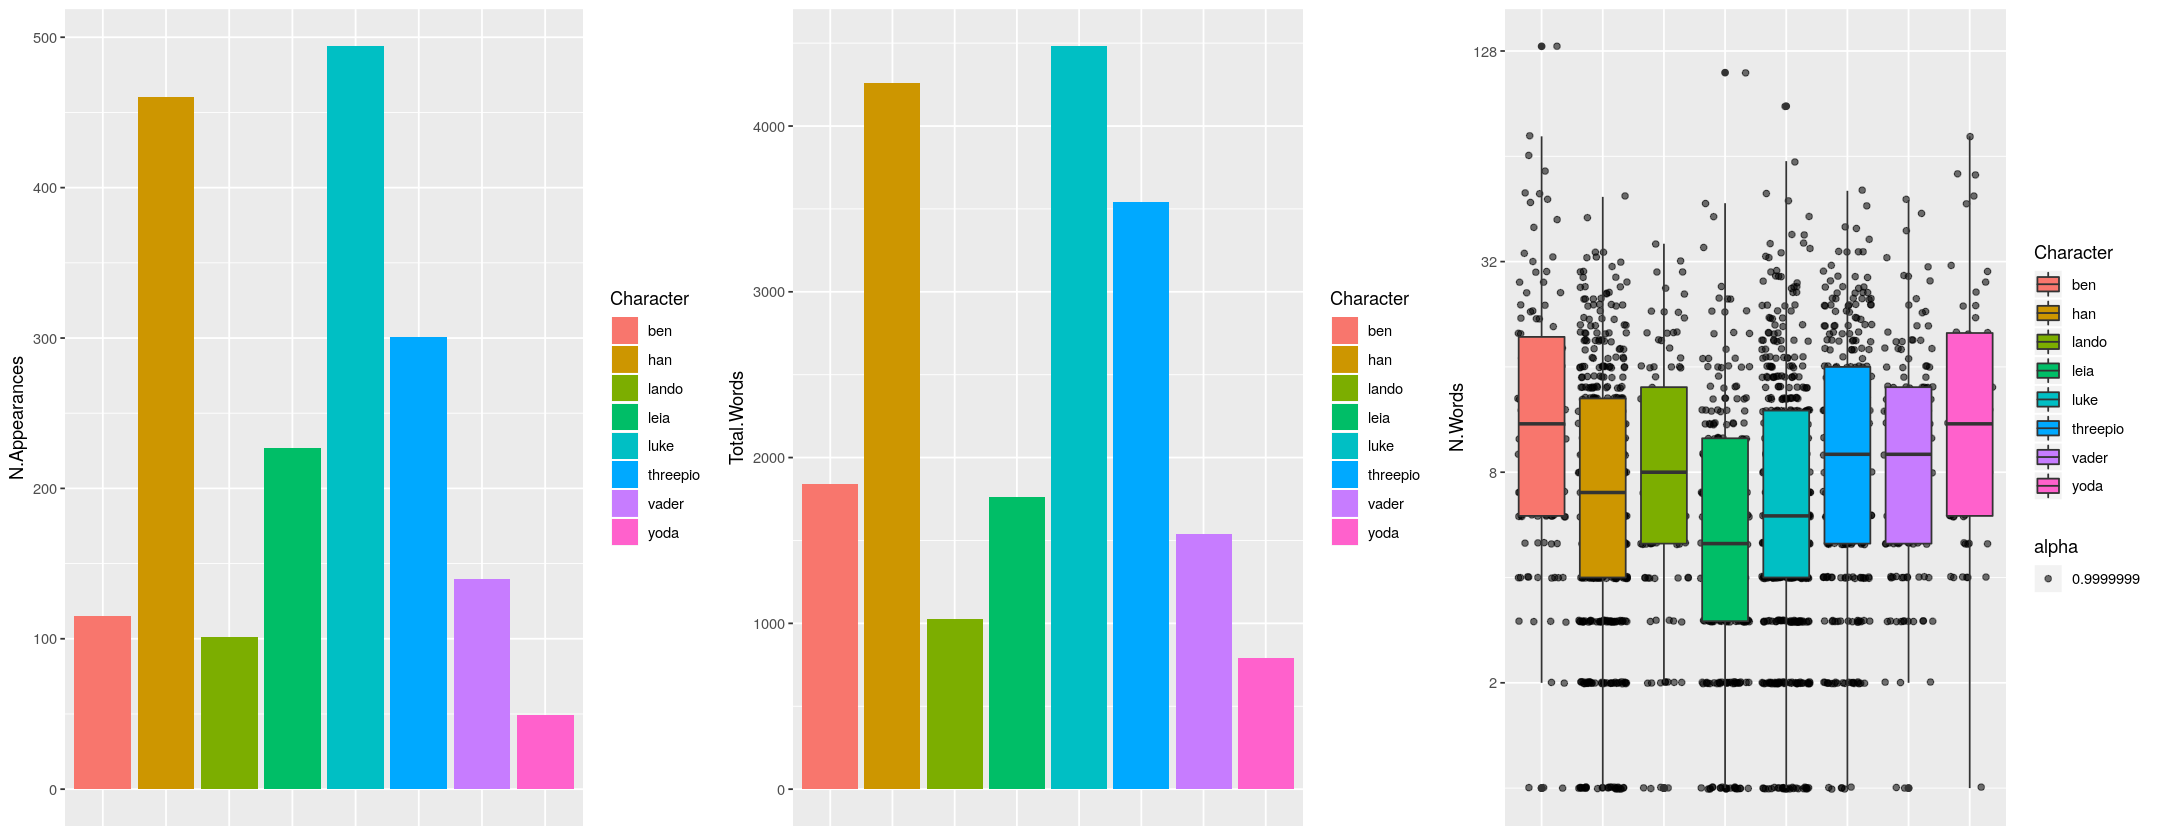

In [55]:
gg1 <- df_main_characters_statistics %>% ggplot(aes(x = Character, y = N.Appearances, fill = Character)) + geom_bar(stat = 'identity')
gg2 <- df_main_characters_statistics %>% ggplot(aes(x = Character, y = Total.Words, fill = Character)) + geom_bar(stat = 'identity')
gg3 <- df_main_characters %>% ggplot(aes(x = Character, y = N.Words, fill = Character)) + 
                                geom_jitter(aes(alpha = 0.9999999)) + geom_boxplot() + scale_y_continuous(trans = log2_trans())

gg1 <- gg1 + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
gg2 <- gg2 + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
gg3 <- gg3 + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())

options(repr.plot.width = 18)
grid.arrange(gg1, gg2, gg3, ncol = 3)
options(repr.plot.width = 8)

In fact, the number of words seems to be strongly correlated with the number of appearances. We can check it by taking the Pearson correlation:

In [56]:
df_all <- df_all %>% mutate(N.Words = lapply(Words.List, (function(X) length(X))) %>% unlist)
df_all_statistics <- df_all %>% group_by(Character) %>% summarise(Total.Words = sum(N.Words), N.Appearances = n()) %>%
                     mutate(Words.Per.Appearance = Total.Words / N.Appearances) %>% as.data.frame
                                                                      
cor(x = df_all_statistics$Total.Words, y = df_all_statistics$N.Appearances, method = 'pearson')

[1] 0.9859604

The correlation is $98.6 \%$. So we are following the right way!

# 1.B. Data Analysis - PART II: Checking the Data

What about the content of the dialogues? Well, we take a general browse on the dialogues using a word cloud diagram, segregated by Characters and by Star Wars Episodes! It will be useful to compare the generated texts with each cloud and, also, we can learn a little bit more about the Star Wars good and old trilogy!

We will, then, show as an example the evolution of Luke for each episode...later, during the testing step, we will check the cloud words with the output of each Neural Network...

In [57]:
df_per_character_and_ep <- df_main_characters %>% 
                           select(c('Character', 'Episode', 'Words.List')) %>%
                           group_by(.dots = c('Character', 'Episode')) %>%
                           summarise(Full.Text = Reduce(c, Words.List) %>% paste(collapse = ' ')) %>% 
                           as.data.frame

df_per_character <- df_main_characters %>% 
                    select(c('Character', 'Episode', 'Words.List')) %>%
                    group_by(.dots = c('Character')) %>%
                    summarise(Full.Text = Reduce(c, Words.List) %>% paste(collapse = ' ')) %>% 
                    as.data.frame

df_per_ep <- df_main_characters %>% 
             select(c('Character', 'Episode', 'Words.List')) %>%
             group_by(.dots = c('Episode')) %>%
             summarise(Full.Text = Reduce(c, Words.List) %>% paste(collapse = ' ')) %>% 
             as.data.frame

characters_list <- unique(df_per_character_and_ep$Character)
episodes_list <- unique(df_per_character_and_ep$Episode)

In [58]:
n.Characters <- nrow(df_per_character)
print.Word.Cloud <- function(character_name = 'ALL', ep = 'ALL'){
    if (ep == 'ALL') {
        df_filter <- df_per_character %>% filter(Character == character_name)
    } else if (character_name == 'ALL') {
        df_filter <- df_per_ep %>% filter(Episode == ep)
    } else {
        df_filter <- df_per_character_and_ep %>% filter(Character == character_name, 
                                                        Episode == ep)
    }
    wordcloud(df_filter$Full.Text[1], max.words = 100, min.freq = 0, colors = brewer.pal(8, "Dark2"))
}

## 1.B1 - Luke on Ep. IV - Word Cloud

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”

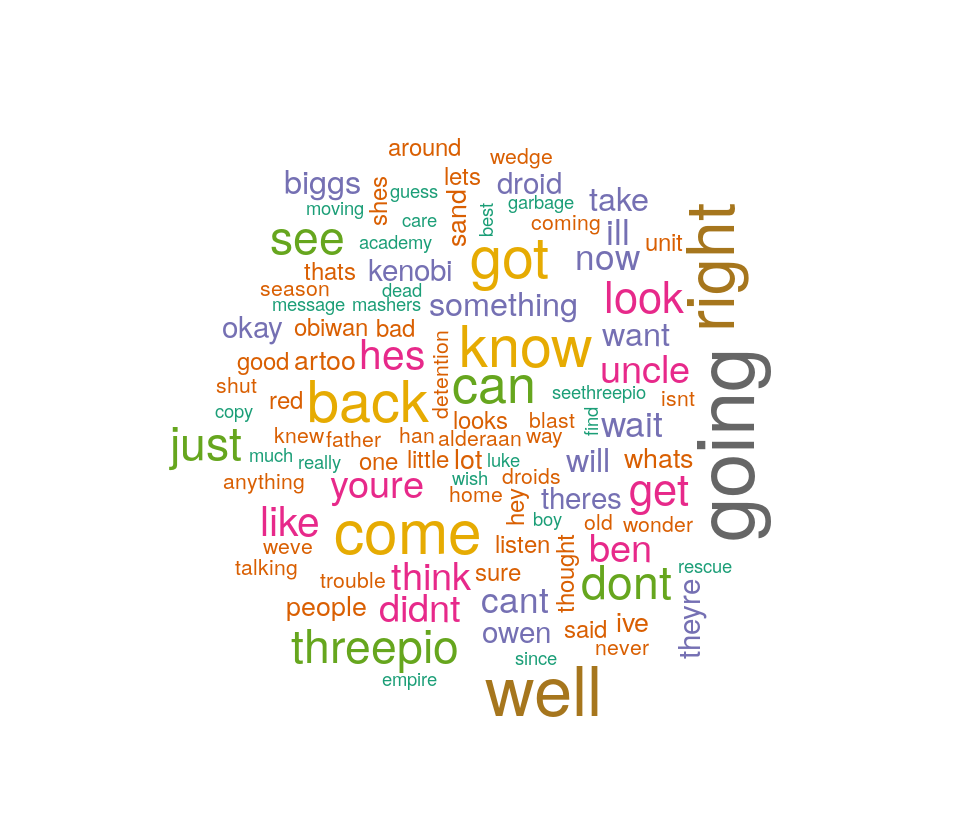

In [59]:
print.Word.Cloud('luke', '4')

Seems that Luke is really concerned with C3PO on the episode IV

## 1.B2 - Luke on Ep. V - Word Cloud

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”

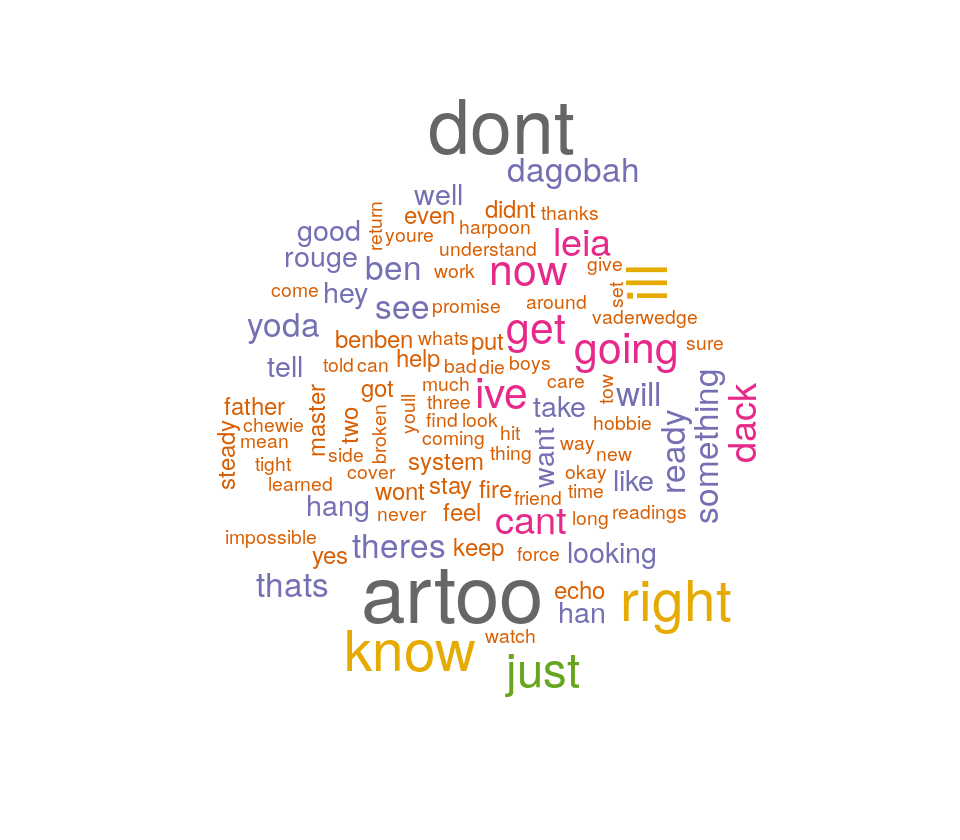

In [60]:
print.Word.Cloud('luke', '5')

In this Episode, Yoda appears and R2D2 (artoo) is repaired...so, it does make sense!

## 1.B3 - Luke on Ep. VI - Word Cloud

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”

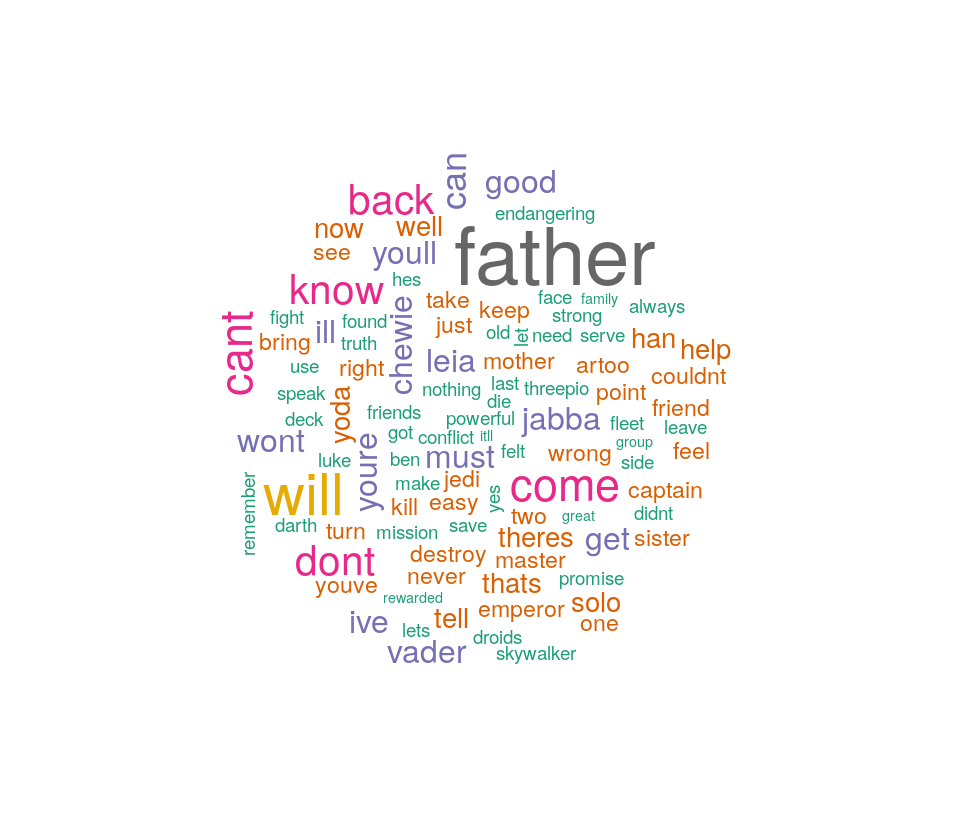

In [61]:
print.Word.Cloud('luke', '6')

Yes! In this episode Luke discovers, effectively, that Darth Vader is **HIS FATHER**! And then, FATHER is just the most spoken Luke's word! (After filtering words like articles or prepositions).

![YAY](https://i0.wp.com/www.meugamer.com/wp-content/uploads/2018/05/luke-i-am-your-father-meugamer.jpg?fit=800%2C450&ssl=1)



# 2. Data Preparation


To train the neural network, we need to encode each word with a different number and organize them in windows, after converting the words list column to a tensor of words. By looking at the boxplot, it seems that a Window with size 5 is interesting - it's not too small and we can get more than 1 window with most of the dialogue texts.

If we have less words than 5 in a dialogue text, we will pad it with "empty" tokens. In this case, we will have "$5 - N_{Words}$" tokens that need to be appended to the tensor. We also have to remove non significant chars and words from the list before doing all this work.

In [62]:
all.words <- reduce(df_all['Words.List'], c)
tokenizer <- text_tokenizer()
tokenizer$fit_on_texts(all.words)

In [63]:
texts_to_sequences(tokenizer, 
                   c('much', 'to', 'learn', 'you', 'still', 'have')) %>% unlist %>% print

[1] 149   4 375   2 269  17


In [64]:
all.words.unique <- all.words %>% unlist %>% unique
words.token <- texts_to_sequences(tokenizer, all.words.unique) %>% unlist

token.Dict <- data.frame(Word = all.words.unique, Code = words.token) %>% arrange(Code)
token.Dict %>% head

Word,Code
<fct>,<int>
the,1
you,2
i,3
to,4
a,5
of,6


In [65]:
take.Windows <- function(dialogue, tokenizer, window.size = 6, step = 1, split = T) {
    text <- if (split) (dialogue %>% strsplit(split = ' ') %>% unlist) else (dialogue)
    text <- texts_to_sequences(tokenizer, text)
    map(seq(1, length(text) - window.size, by = step), ~text[.x:(.x + window.size)]) %>% return
}

test <- 'much to learn you still have my jedi warrior' %>% take.Windows(tokenizer = tokenizer)
test

[[1]]
[[1]][[1]]
[1] 149

[[1]][[2]]
[1] 4

[[1]][[3]]
[1] 375

[[1]][[4]]
[1] 2

[[1]][[5]]
[1] 269

[[1]][[6]]
[1] 17

[[1]][[7]]
[1] 19


[[2]]
[[2]][[1]]
[1] 4

[[2]][[2]]
[1] 375

[[2]][[3]]
[1] 2

[[2]][[4]]
[1] 269

[[2]][[5]]
[1] 17

[[2]][[6]]
[1] 19

[[2]][[7]]
[1] 119


[[3]]
[[3]][[1]]
[1] 375

[[3]][[2]]
[1] 2

[[3]][[3]]
[1] 269

[[3]][[4]]
[1] 17

[[3]][[5]]
[1] 19

[[3]][[6]]
[1] 119

[[3]][[7]]
[1] 900

In [66]:
get.Character.Windows <- function(character.Name, tokenizer, window.size = 6) {
    full.window <-  take.Windows(dialogue = (df_per_character %>% filter(Character == character.Name))[1, 'Full.Text'], tokenizer = tokenizer)             
    
    X_out <- lapply(full.window, function(X)(X[1:(window.size - 1)]))
    Y_out <- lapply(full.window, function(X)(X[2:window.size]))
                    
    to.Mat <- function(X) {
        do.call(rbind, lapply(X, rbind)) %>% return
    }
                    
    to.Array <- function(X, add_dim) {
        final_dim = c(nrow(X), ncol(X))
        array(unlist(X), final_dim) %>% return
    }
                    
    return(list(X = X_out %>% to.Mat %>% to.Array(add_dim = T), 
                Y = Y_out %>% to.Mat %>% to.Array(add_dim = F)))
}
                    
('yoda' %>% get.Character.Windows(tokenizer = tokenizer))$X %>% dim
('yoda' %>% get.Character.Windows(tokenizer = tokenizer))$Y %>% dim

[1] 788   5

[1] 788   5

# 3. Creating and Tunning the Model

In [67]:
gen.Model <- function(n_units = 5, 
                      do_rate = 0.2, 
                      max_id = length(tokenizer$word_index), 
                      batch_size = 32,
                      window_size = 5){
    
    model <- keras_model_sequential()
    
    model %>%
    
        layer_gru(units = n_units,
                  return_sequences = T,
                  input_shape = c(window_size, 1),
                  dropout = do_rate,
                  recurrent_dropout = do_rate) %>%
    
        layer_gru(units = n_units, 
                  return_sequences = T, 
                  dropout = do_rate,
                  recurrent_dropout = do_rate) %>%
    
        time_distributed(layer = 
        layer_dense(units = max_id, activation = 'softmax'))
    
    model %>% compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy') %>% return
}

gen.Model() %>% summary

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_8 (GRU)                         (None, 5, 5)                    105         
________________________________________________________________________________
gru_9 (GRU)                         (None, 5, 5)                    165         
________________________________________________________________________________
time_distributed_4 (TimeDistributed (None, 5, 2983)                 17898       
Total params: 18,168
Trainable params: 18,168
Non-trainable params: 0
________________________________________________________________________________


In [68]:
n.Epochs <- 1000
batch.Size <- 32

es_cb <- EarlyStopping(patience = 5)
dataset <- get.Character.Windows('han', tokenizer)
model <- gen.Model()
model %>% summary
X_in <- dataset$X
Y_in <- to_categorical(dataset$Y - 1, num_classes = length(tokenizer$word_index))

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_10 (GRU)                        (None, 5, 5)                    105         
________________________________________________________________________________
gru_11 (GRU)                        (None, 5, 5)                    165         
________________________________________________________________________________
time_distributed_5 (TimeDistributed (None, 5, 2983)                 17898       
Total params: 18,168
Trainable params: 18,168
Non-trainable params: 0
________________________________________________________________________________


In [69]:
X_in %>% dim %>% print
Y_in %>% dim %>% print

length(tokenizer$word_index) %>% print

[1] 4254    5
[1] 4254    5 2983
[1] 2983


In [70]:
model %>% fit(x = X_in[1:32,] %>% array_reshape(c(32, 5, 1)), y = Y_in[1:32,,],
              batch_size = batch.Size,
              epochs = n.Epochs,
              callbacks = c(es_cb),
              verbose = 1)

In [71]:
X_in[1:10,] %>% dim %>% print

[1] 10  5


In [72]:
predict_test <- model %>% predict(X_in[1:10,] %>% array_reshape(c(10, 5, 1)))
predict_test %>% dim %>% print

[1]   10    5 2983


In [73]:
predict_test[1, 1,] %>% drop %>% sum

[1] 1

# 4. Generate Text from Model

In [74]:
strsplit('much to learn you still', split = ' ') %>% unlist %>% length

[1] 5

[1] "Generated Word:"
[1] "system"
[1] "Generated Sentence:"
[1] "Much to learn you still [ system ]"


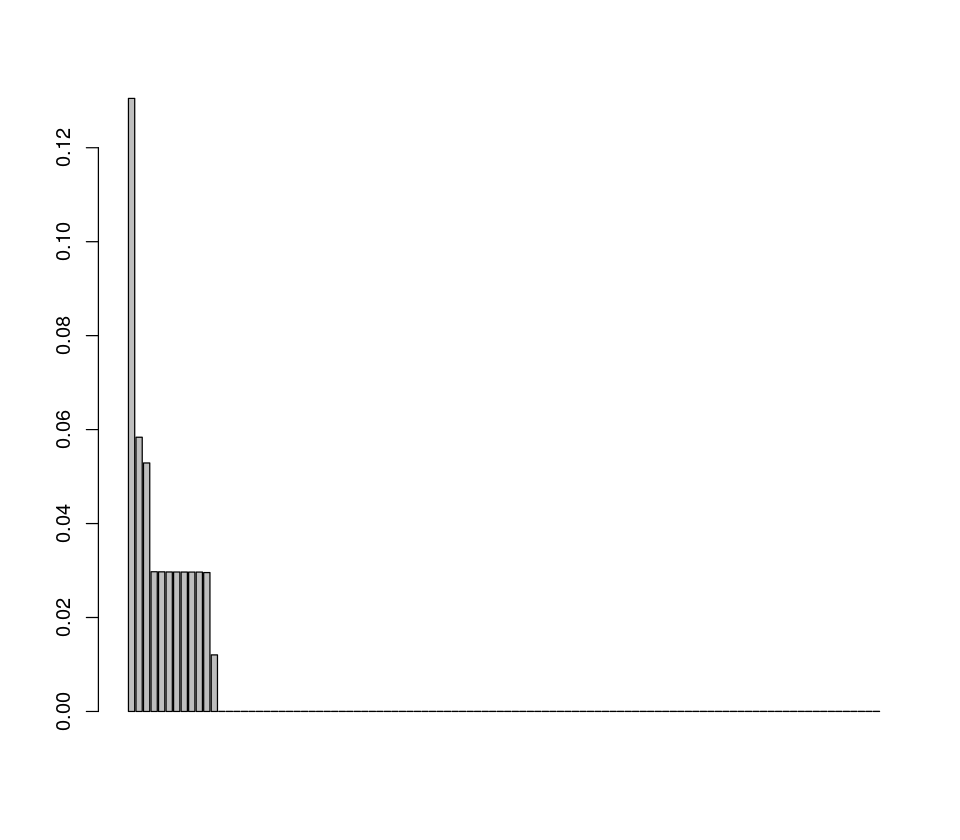

In [75]:
get_next_word <- function(model, initial.Window, temperature = 1, verbose = 0){
    
    seq.Tokens <- texts_to_sequences(tokenizer, initial.Window)
    n.Words <- length(seq.Tokens %>% unlist)
    
    X.in <- seq.Tokens %>% array_reshape(c(1, n.Words, 1))
    model.Prediction <- (model %>% predict(X.in))[, 5,] %>% drop
    
    adjusted.Distribution <- exp(log(model.Prediction) / temperature)
    adjusted.Distribution <- adjusted.Distribution / sum(adjusted.Distribution)
    
    rand.n <- runif(1, 0, 1)
    cdf <- 0
    index <- 0
    
    while(cdf < rand.n){
        index <- index + 1
        prob <- adjusted.Distribution[[index]]
        cdf <- cdf + prob
    }
    
    if (verbose > 0) { barplot(adjusted.Distribution[1:100] %>% sort(decreasing = T)) }
    output.Row <- token.Dict %>% filter(Code == index)
    return(output.Row$Word[1] %>% as.character)
}

# Text to test: 'much to learn you still' -- Code: 149, 4, 375, 2, 269
print('Generated Word:')
test.Out.Word <- get_next_word(model, 'much to learn you still', 1, 1)
test.Out.Word %>% print

print('Generated Sentence:')
paste('Much to learn you still [', test.Out.Word, ']') %>% print

In [76]:
gen.Text <- function(initial.Window, model, n.Words = 8, temperature = 2) {
    ans <- initial.Window
    last.Word <- ''
    for (i in 1:n.Words) {
        words.list <- initial.Window %>% strsplit(split = ' ') %>% unlist
        next.Word <- get_next_word(model, initial.Window, temperature = temperature)
        if (last.Word != next.Word) { ans <- paste(ans, next.Word, collapse = ' ')  }
        initial.Window <- paste(c(words.list[2:length(words.list)] %>% unlist, c(next.Word)), collapse = ' ')
        last.Word <- next.Word
    }
    return(ans)
}

gen.Text('hello i\'m a person that', model)

[1] "hello i'm a person that meaning destroyers sector abandon triumph here hermit chewie"

# 5. Train the Model for Each Character, Enjoy and Take Conclusions :)

In [77]:
main_characters_list <- df_main_characters['Character'] %>% unique %>% as.list
main_characters_list <- main_characters_list$Character
main_characters_list %>% print

[1] "threepio" "luke"     "vader"    "leia"     "ben"      "han"      "yoda"    
[8] "lando"   


In [78]:
character.Text.Generator <- function(curr_character) {
    
    all.words <- all.words <- reduce((df_all %>% filter(Character == curr_character))['Words.List'] %>% unlist, c)

    tokenizer <- text_tokenizer()
    tokenizer$fit_on_texts(all.words)
    
    curr_train_data <- get.Character.Windows(curr_character, tokenizer)
    
    X_in <- curr_train_data$X
    X_in <- X_in %>% array_reshape(c(dim(X_in)[1], dim(X_in)[2], 1))
    
    Y_in <- curr_train_data$Y
    max_id = length(tokenizer$word_index)
    Y_in <- to_categorical(Y_in - 1, num_classes = max_id)
    
    model <- gen.Model(max_id = max_id)
    model %>% fit(x = X_in, y = Y_in,
                  batch_size = batch.Size,
                  epochs = n.Epochs,
                  callbacks = c(es_cb),
                  verbose = 1)
    
    return(model)
}

In [79]:
print('Training C3PO text generator')
threepio_model <- character.Text.Generator('threepio')
print('OK')

[1] "Training C3PO text generator"
[1] "OK"


In [80]:
print('Training Luke text generator...')
luke_model <- character.Text.Generator('luke')
print('OK')

[1] "Training Luke text generator..."


In [ ]:
print('Traning Vader text generator...')
vader_model <- character.Text.Generator('vader')
print('OK')

In [ ]:
print('Training Yoda text generator...')
yoda_model <- character.Text.Generator('yoda')
print('OK')